In [1]:
from __future__ import print_function, division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import datetime
from datetime import datetime as dt
import seaborn as sns 

In [2]:
# Source: http://web.mta.info/developers/turnstile.html
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [160903, 160910, 160917]
turnstiles_df = get_data(week_nums)
turnstiles_df = turnstiles_df.reset_index(drop=True)

In [3]:
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]

In [4]:
# Take the date and time fields into a single datetime column
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [5]:
turnstiles_df["Day_Name"] = turnstiles_df["DATE_TIME"].dt.day_name()

In [6]:
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,Day_Name
0,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,00:00:00,REGULAR,5799442,1966041,2016-08-27 00:00:00,Saturday
1,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,04:00:00,REGULAR,5799463,1966044,2016-08-27 04:00:00,Saturday
2,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,08:00:00,REGULAR,5799492,1966079,2016-08-27 08:00:00,Saturday
3,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,12:00:00,REGULAR,5799610,1966155,2016-08-27 12:00:00,Saturday
4,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,16:00:00,REGULAR,5799833,1966214,2016-08-27 16:00:00,Saturday


In [7]:
#remove the weekends
df_weekdays = turnstiles_df[(turnstiles_df["Day_Name"] != "Saturday") & (turnstiles_df["Day_Name"] != "Sunday")]

In [8]:
df_weekdays.Day_Name.unique()

array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
      dtype=object)

In [9]:
df_weekdays['Turnstile'] = df_weekdays['C/A'] + df_weekdays['UNIT'] + df_weekdays['SCP']

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
df_weekdays['bins'] = df_weekdays.groupby(["Turnstile", "DATE"]).cumcount()

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
#draft
df_weekdays.groupby(['bins','TIME']).TIME.count()
#df_weekdays[df_weekdays['bins' <= 2 & bins >= 3]].groupby(['bins','TIME']).TIME.count()

bins  TIME    
0     00:00:00    36181
      00:00:02        2
      00:00:11        1
      00:00:15        1
      00:00:19        2
                  ...  
12    16:00:00        4
      17:00:00        5
      21:00:00        7
13    20:00:00        4
      21:00:00        5
Name: TIME, Length: 16026, dtype: int64

In [12]:
# Get rid of the duplicate entry
df_weekdays.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
df_weekdays.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [13]:
df_weekdays.shape

(416988, 15)

In [14]:
df_weekdays[["PREV_DATE", "PREV_ENTRIES"]] = (df_weekdays
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [15]:
df_weekdays[["PREV_DATE", "PREV_EXITS"]] = (df_weekdays
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "EXITS"]
                                                       .apply(lambda grp: grp.shift(1)))

In [16]:
df_weekdays.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,Day_Name,Turnstile,bins,PREV_DATE,PREV_ENTRIES,PREV_EXITS
580894,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/16/2016,21:00:00,REGULAR,5554,271,2016-09-16 21:00:00,Friday,TRAM2R46900-05-01,5,NaN,NaN,NaN
580893,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/16/2016,17:00:00,REGULAR,5554,271,2016-09-16 17:00:00,Friday,TRAM2R46900-05-01,4,09/16/2016,5554.0,271.0
580892,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/16/2016,13:00:00,REGULAR,5554,271,2016-09-16 13:00:00,Friday,TRAM2R46900-05-01,3,09/16/2016,5554.0,271.0
580891,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/16/2016,09:00:00,REGULAR,5554,271,2016-09-16 09:00:00,Friday,TRAM2R46900-05-01,2,09/16/2016,5554.0,271.0
580890,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/16/2016,05:00:00,REGULAR,5554,271,2016-09-16 05:00:00,Friday,TRAM2R46900-05-01,1,09/16/2016,5554.0,271.0


In [17]:
# Drop the rows for the earliest date in the df
df_weekdays.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
df_weekdays["DAILY_ENTRIES"] = df_weekdays.apply(get_daily_counts, axis=1, max_counter=100000)

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
def get_daily_counts(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
df_weekdays["DAILY_EXITS"] = df_weekdays.apply(get_daily_counts, axis=1, max_counter=100000)

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
df_weekdays.rename(columns = {'DAILY_EXITS':'HOURLY_EXITS','DAILY_ENTRIES':'HOURLY_ENTRIES' }, inplace=True)

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [21]:
#sum(df_weekdays["DAILY_ENTRIES"] != 0.0)

In [22]:
#df_weekdays['bins'].mean()

In [23]:
df_final = df_weekdays[(df_weekdays["TIME"] >= "07:00:00") & (df_weekdays["TIME"] <= "11:00:00")]

In [24]:
df_final['HOURLY_ENTRIES'].describe()

count    74830.000000
mean       252.718776
std        583.664987
min          0.000000
25%         44.000000
50%        161.000000
75%        353.000000
max      98988.000000
Name: HOURLY_ENTRIES, dtype: float64

In [25]:
df_final['HOURLY_EXITS'].describe()

count    74830.000000
mean       218.304143
std        767.275580
min          0.000000
25%         25.000000
50%         96.000000
75%        261.000000
max      97034.000000
Name: HOURLY_EXITS, dtype: float64

In [26]:
df_final.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,Day_Name,Turnstile,bins,PREV_DATE,PREV_ENTRIES,PREV_EXITS,HOURLY_ENTRIES,HOURLY_EXITS
580891,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/16/2016,09:00:00,REGULAR,5554,271,2016-09-16 09:00:00,Friday,TRAM2R46900-05-01,2,09/16/2016,5554.0,271.0,0.0,0.0
580885,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/15/2016,09:00:00,REGULAR,5554,271,2016-09-15 09:00:00,Thursday,TRAM2R46900-05-01,2,09/15/2016,5554.0,271.0,0.0,0.0
580879,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/14/2016,09:00:00,REGULAR,5554,271,2016-09-14 09:00:00,Wednesday,TRAM2R46900-05-01,2,09/14/2016,5554.0,271.0,0.0,0.0
580873,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/13/2016,09:00:00,REGULAR,5554,271,2016-09-13 09:00:00,Tuesday,TRAM2R46900-05-01,2,09/13/2016,5554.0,271.0,0.0,0.0
580867,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/12/2016,09:00:00,REGULAR,5554,271,2016-09-12 09:00:00,Monday,TRAM2R46900-05-01,2,09/12/2016,5554.0,271.0,0.0,0.0


In [27]:
# first get daily entries by station
#exits, not entries
work_week_entries = \
(df_final.groupby(['STATION'])['HOURLY_EXITS'].sum()
                 .reset_index())

work_week_entries.head()

,STATION,HOURLY_EXITS
0,1 AV,72797.0
1,103 ST,51323.0
2,103 ST-CORONA,21744.0
3,104 ST,3394.0
4,110 ST,22812.0


In [28]:
# then get top 10 stations by daily volume 
# (sum across all days is a reasonable way to define this)
top10_stations = \
    (work_week_entries.groupby(['STATION'])['HOURLY_EXITS'].sum()
                   .reset_index()
                   .sort_values(by='HOURLY_EXITS',ascending=False) 
                   .STATION.head(10))

top10_stations

230    GRD CNTRL-42 ST
59     34 ST-HERALD SQ
223          FULTON ST
72      47-50 STS ROCK
46               23 ST
348     TIMES SQ-42 ST
61      34 ST-PENN STA
14      14 ST-UNION SQ
177        CHAMBERS ST
85               59 ST
Name: STATION, dtype: object

In [29]:
# next create a new df that filters the stations daily data down
# to the top 10 stations
stations_hourly_top10 = \
    work_week_entries[work_week_entries['STATION'].isin(top10_stations)]
stations_hourly_top10.sort_values(by = 'HOURLY_EXITS', ascending = True, inplace = True)

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


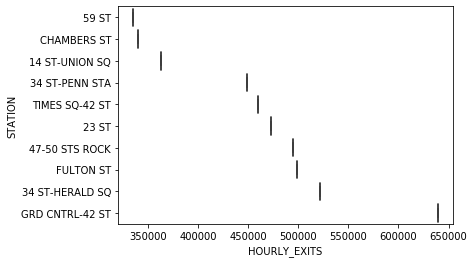

In [30]:
# use seaborn to create a boxplot by station
sns.boxplot('HOURLY_EXITS', 'STATION', data=stations_hourly_top10)

<BarContainer object of 10 artists>

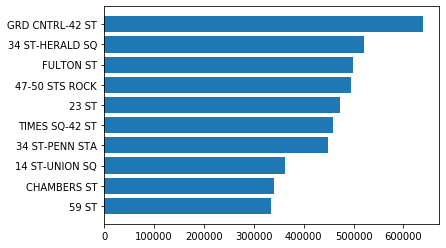

In [31]:
#top_10 =mta_h1.groupby(['Station']).agg({'busy': sum}).sort_values(by = 'busy', ascending = False).head(10)

#fig, ax = plt.subplots(figsize=(25, 8))
#top_10.sort_values(by = 'busy',ascending=True).plot(kind='barh', color ='orange',ax=ax)
#ax.set(title='Top 10 Stations by Total Entries and Exits (January-June 2018)', xlabel='total traffic', ylabel='')
#ax.legend().set_visible(False)

plt.barh(stations_hourly_top10['STATION'], stations_hourly_top10['HOURLY_EXITS'])
#new_x = np.arange(20)
#new_y = np.random.randint(5,10,20)
#plt.barh(new_x,new_y);


In [32]:
#which line commute to Grand Central 
df_final[df_final['STATION'] == 'GRD CNTRL-42 ST'].LINENAME.unique()

array(['4567S'], dtype=object)

In [33]:
#we choose 1 line form these: we chose 4 to start with  

In [34]:
df_final[df_final['LINENAME'].str.contains('4')].STATION.unique() 

array(['CROWN HTS-UTICA', 'FRANKLIN AV', 'ATL AV-BARCLAY', 'NEVINS ST',
       'BOROUGH HALL', 'WOODLAWN', 'MOSHOLU PKWY', 'BEDFORD PK BLVD',
       'KINGSBRIDGE RD', 'FORDHAM RD', '183 ST', 'BURNSIDE AV', '176 ST',
       'MT EDEN AV', '170 ST', '167 ST', '161/YANKEE STAD',
       '149/GRAND CONC', '138/GRAND CONC', '125 ST', '86 ST', '59 ST',
       'GRD CNTRL-42 ST', '14 ST-UNION SQ', 'BROOKLYN BRIDGE',
       'FULTON ST', 'WALL ST', 'BOWLING GREEN', 'BOTANIC GARDEN',
       'CHAMBERS ST'], dtype=object)

In [35]:
df_final[df_final['LINENAME'].str.contains('5')].STATION.unique() 

array(['EASTCHSTER/DYRE', 'BAYCHESTER AV', 'GUN HILL RD', 'PELHAM PKWY',
       'MORRIS PARK', 'FLATBUSH AV-B.C', 'NEWKIRK AV', 'BEVERLY RD',
       'CHURCH AV', 'WINTHROP ST', 'STERLING ST', 'PRESIDENT ST',
       'FRANKLIN AV', 'ATL AV-BARCLAY', 'NEVINS ST', 'BOROUGH HALL',
       'NEREID AV', '233 ST', '225 ST', '219 ST', 'BURKE AV',
       'ALLERTON AV', 'BRONX PARK EAST', 'E 180 ST', 'WEST FARMS SQ',
       '174 ST', 'FREEMAN ST', 'SIMPSON ST', 'INTERVALE AV',
       'PROSPECT AV', 'JACKSON AV', '3 AV-149 ST', '149/GRAND CONC',
       '138/GRAND CONC', '125 ST', '86 ST', '59 ST', 'GRD CNTRL-42 ST',
       '14 ST-UNION SQ', 'BROOKLYN BRIDGE', 'FULTON ST', 'WALL ST',
       'BOWLING GREEN', 'BOTANIC GARDEN', 'CHAMBERS ST'], dtype=object)

In [36]:
stations_4_5 = ['CROWN HTS-UTICA', 'FRANKLIN AV', 'ATL AV-BARCLAY', 'NEVINS ST','BOROUGH HALL', 'PRESIDENT ST', 'STERLING ST','WINTHROP ST', 'CHURCH AV', 'BEVERLY RD', 'NEWKIRK AV']

In [37]:
df_4_5_Brooklyn = df_final[df_final['STATION'].isin(stations_4_5)] 

In [38]:
df_4_5_Brooklyn.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,Day_Name,Turnstile,bins,PREV_DATE,PREV_ENTRIES,PREV_EXITS,HOURLY_ENTRIES,HOURLY_EXITS
577440,R644,R135,01-06-01,NEWKIRK AV,25,IRT,09/16/2016,09:46:46,REGULAR,500911,8541542,2016-09-16 09:46:46,Friday,R644R13501-06-01,3,09/16/2016,500924.0,8541690.0,13.0,148.0
577439,R644,R135,01-06-01,NEWKIRK AV,25,IRT,09/16/2016,09:00:00,REGULAR,500907,8541502,2016-09-16 09:00:00,Friday,R644R13501-06-01,2,09/16/2016,500911.0,8541542.0,4.0,40.0
577433,R644,R135,01-06-01,NEWKIRK AV,25,IRT,09/15/2016,09:00:00,REGULAR,500808,8539409,2016-09-15 09:00:00,Thursday,R644R13501-06-01,2,09/15/2016,500827.0,8539675.0,19.0,266.0
577427,R644,R135,01-06-01,NEWKIRK AV,25,IRT,09/14/2016,09:00:00,REGULAR,500724,8537398,2016-09-14 09:00:00,Wednesday,R644R13501-06-01,2,09/14/2016,500743.0,8537622.0,19.0,224.0
577421,R644,R135,01-06-01,NEWKIRK AV,25,IRT,09/13/2016,09:00:00,REGULAR,500645,8535400,2016-09-13 09:00:00,Tuesday,R644R13501-06-01,2,09/13/2016,500663.0,8535628.0,18.0,228.0


In [42]:
# first get daily entries by station
work_week_entries = \
(df_4_5_Brooklyn.groupby(['STATION'])['HOURLY_ENTRIES'].sum()
                 .reset_index())

work_week_entries.sort_values(by = 'HOURLY_ENTRIES', ascending = True, inplace = True)

<BarContainer object of 11 artists>

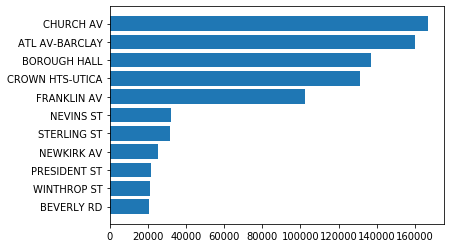

In [43]:
plt.barh(work_week_entries['STATION'], work_week_entries['HOURLY_ENTRIES'])

In [46]:
len(stations_4_5)/4


2.75

In [47]:
stations_4_5

['CROWN HTS-UTICA',
 'FRANKLIN AV',
 'ATL AV-BARCLAY',
 'NEVINS ST',
 'BOROUGH HALL',
 'PRESIDENT ST',
 'STERLING ST',
 'WINTHROP ST',
 'CHURCH AV',
 'BEVERLY RD',
 'NEWKIRK AV']